<a href="https://colab.research.google.com/github/ThunderWiring/learning-computer-vision/blob/main/image_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Noise Filtering

## Salt and Pepper (SaP)

This type of noise is created by an impulses in the image.

Will take the following image, and add to it the SaP noise, then try to restore the original image using different methods.

In [211]:
import cv2 as cv 
import numpy as np
from skimage import io
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision

import requests
from PIL import Image
from google.colab import drive
import sys

drive.mount('/content/drive')
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(800, 567)


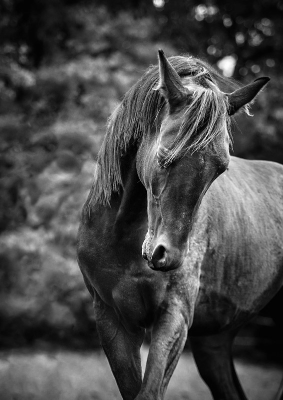

In [212]:
url = 'https://blog.54ka.org/wp-content/uploads/2016/11/black-and-white-portrait-of-horse_by_54ka.jpg'
orig_image = io.imread(url)[0:800, 0:567]
image_gray = cv.cvtColor(orig_image, cv.COLOR_BGR2GRAY)
print(image_gray.shape)
scale = 0.5
image_gray = cv.resize(image_gray, (int(scale * image_gray.shape[1]), int(scale * image_gray.shape[0])))
cv2_imshow(image_gray)

Now, let's add some salt and pepper noise to the image `image_gray`

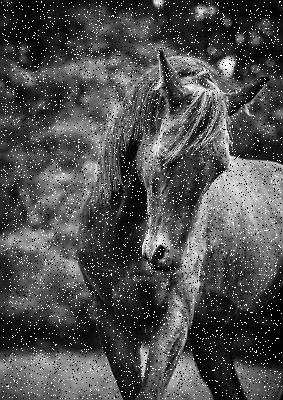

In [213]:
def noise(img,snr):
  #snr = signal to noise ratio is a number in [0, 1]
  h=img.shape[0]
  w=img.shape[1]
  img1=img.copy()
  sp=h*w # Calculate the number of image pixels
  NP=int(sp*(1-snr)) # Calculate the number of image salt and pepper noise points
  for i in range (NP):
    randx=np.random.randint(1,h-1) # Generate a random integer between 1 and h-1
    randy=np.random.randint(1,w-1) # Generate a random integer between 1 and w-1
    if np.random.random()<=0.5: # np.random.random() generates a floating point number between 0 and 1.
      img1[randx,randy]=0
    else:
      img1[randx,randy]=255
  return img1

noisy_img = noise(image_gray, 0.9)
cv2_imshow(noisy_img)

First attempt is to perform average filter on the image. For this will do a box filter convolution on the image. 

The kernel for this is:

$kernel = \frac{1}{9}
 \begin{pmatrix}
  1 & 1 & 1 \\
  1 & 1 & 1 \\
  1 & 1 & 1
 \end{pmatrix}$



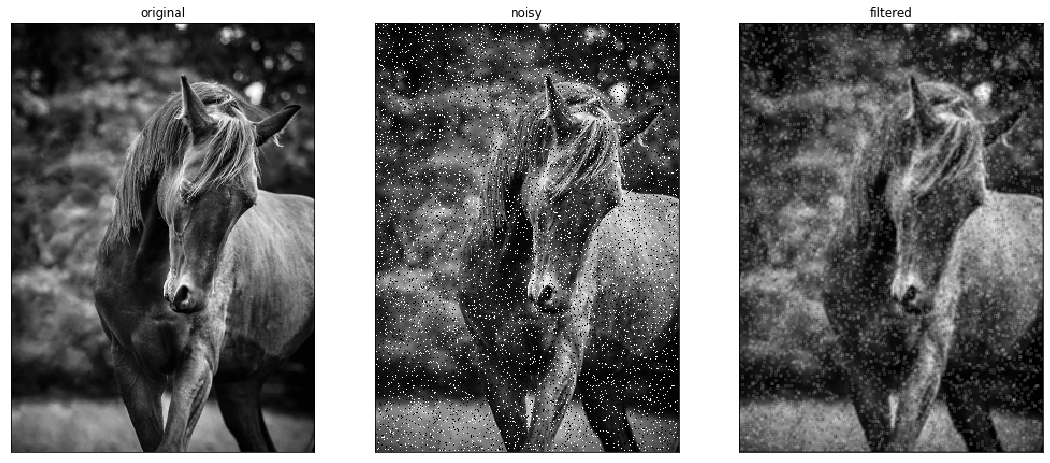

In [214]:
import scipy.signal as sig

filter = 1/9 * np.array(
    [
     [1,1,1],
     [1,1,1],
     [1,1,1],
    ]
)
filtered = sig.convolve2d(noisy_img, filter, mode='same')
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
title = ['original', 'noisy', 'filtered']
for i, img in enumerate([image_gray, noisy_img, filtered]):
  plt.subplot(1,3,i+1)
  plt.imshow(img, cmap='gray', interpolation='none')
  plt.title(title[i])
  plt.xticks([])
  plt.yticks([])

Although the noise got reduced, but so did the quality of the image.

Next approach will be similar in terms of using the surrounding pixels to learn more whether there is a noise and how to deal with it.

The SaP noise is a steep change in colors, therefore will see when the gradient of the image changes abrubtly, then try to correct that change by interpolating the noisy area using the 8-size neighbourhood of the pixel.

To calculate the gradient in the X and Y directions, will use the Sobel operator:

$G_{x} =
 \begin{pmatrix}
  1 & 0 & -1 \\
  2 & 0 & -2 \\
  1 & 0 & -1 \\
 \end{pmatrix}$
 
$G_{y} = 
 \begin{pmatrix}
  1 & 2 & 1 \\
  0 & 0 & 0 \\
  -1 & -2 & -1 \\
 \end{pmatrix}$

 The filter for the Y direction is the transpose of the X direction.

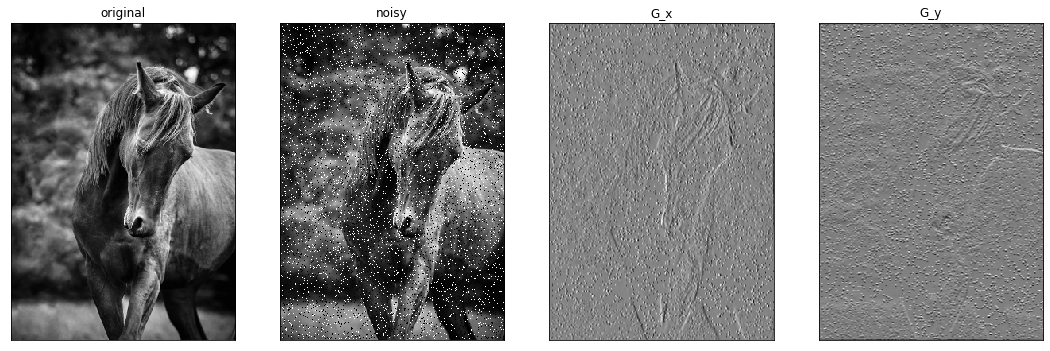

In [215]:
dX = np.array([
                  [1, 0, -1],
                  [2, 0, -2],
                  [1, 0, -1],
                ])
dY = dX.T
# smooth image while keeping edges sharp
smoothed_noisy_img = cv.bilateralFilter(noisy_img,1,50,50) 

G_x = sig.convolve2d(smoothed_noisy_img, dX, mode='same') # gradient in the X direction
G_y = sig.convolve2d(smoothed_noisy_img, dY, mode='same') # gradient in the Y direction

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
title = ['original', 'noisy', 'G_x', 'G_y']
for i, img in enumerate([image_gray, noisy_img, G_x, G_y]):
  plt.subplot(1,len(title),i+1)
  plt.imshow(img, cmap='gray', interpolation='none')
  plt.title(title[i])
  plt.xticks([])
  plt.yticks([])

max grad_x 911 , max grad_y 1008
min grad_x -977 , min grad_y -1005


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in ubyte_scalars
  app.launch_new_instance()


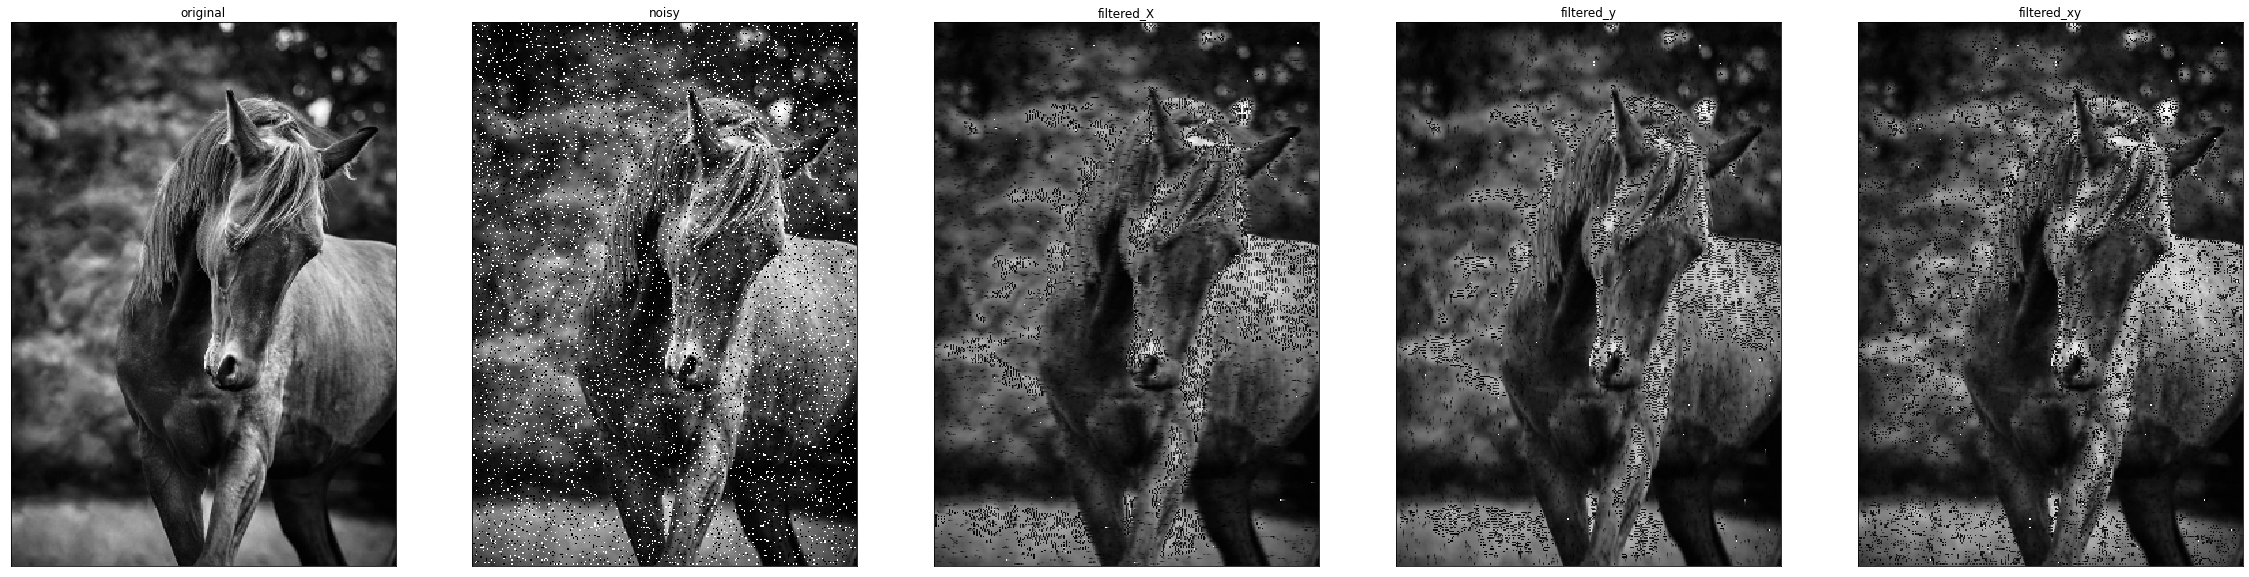

In [216]:
rows, cols = G_x.shape[0], G_x.shape[1]
print('max grad_x', np.max(G_x), ', max grad_y', np.max(G_y))
print('min grad_x', np.min(G_x), ', min grad_y', np.min(G_y))
deltas = np.zeros((rows, cols))
filtered_x = np.array(smoothed_noisy_img)
filtered_y = np.array(smoothed_noisy_img)
filtered_xy = np.array(smoothed_noisy_img)
threshold = 150
min_th = -150

for row in range(1, int(rows - 1)):
  for col in range(1, int(cols - 1)):
    dx = abs(G_x[row, col - 1] - G_x[row, col + 1])
    dy = abs(G_y[row - 1, col] - G_y[row + 1, col])
    if dx > threshold or dx < min_th:
      filtered_x[row, col] = 0.5 * (filtered_x[row, col - 1] + filtered_x[row, col + 1])
    if dy > threshold or dy < min_th:
      filtered_y[row, col] = 0.5 * (filtered_y[row - 1, col] + filtered_y[row + 1, col])
    if (dy > threshold and dx > threshold) or (dy < min_th and dx < min_th):
      filtered_xy[row, col] = 0.25 * (filtered_xy[row - 1, col] + filtered_xy[row + 1, col] + filtered_xy[row, col - 1] + filtered_xy[row, col + 1])
    


fig = plt.figure(figsize=(40,40))
title = ['original', 'noisy', 'filtered_X', 'filtered_y', 'filtered_xy']
for i, img in enumerate([image_gray, noisy_img, filtered_x, filtered_y, filtered_xy]):
  plt.subplot(1,len(title),i+1)
  plt.imshow(img, cmap='gray', interpolation='none')
  plt.title(title[i])
  plt.xticks([])
  plt.yticks([])

the denoised images show a good improvement compared to the noisy one, as well as it didn't blur the image.
How can this be further improved?

There are 2 approaches to take in order to enhance the result
1. the threshold on the derivative
2. Taking different sizes of the image (pyramid) and trying to locate the noisy part (places where there are local maxima/minima), this will indicate high chance of a noisy part.

## Median Filter

The reason an avg filter gives relativly bad results is because the SaP is a spike in the intensity, meaning most pixels in the noise-spike neighbourhood are close in intensity except for that spike. 

The median is the value in the middle, and in this case, no matter the magnitude of the noise intensity, it will not change the median pixel value or any other pixel in this neighbourhood for this matter.


In the following will try to find a spike in the intensity and apply the median filter

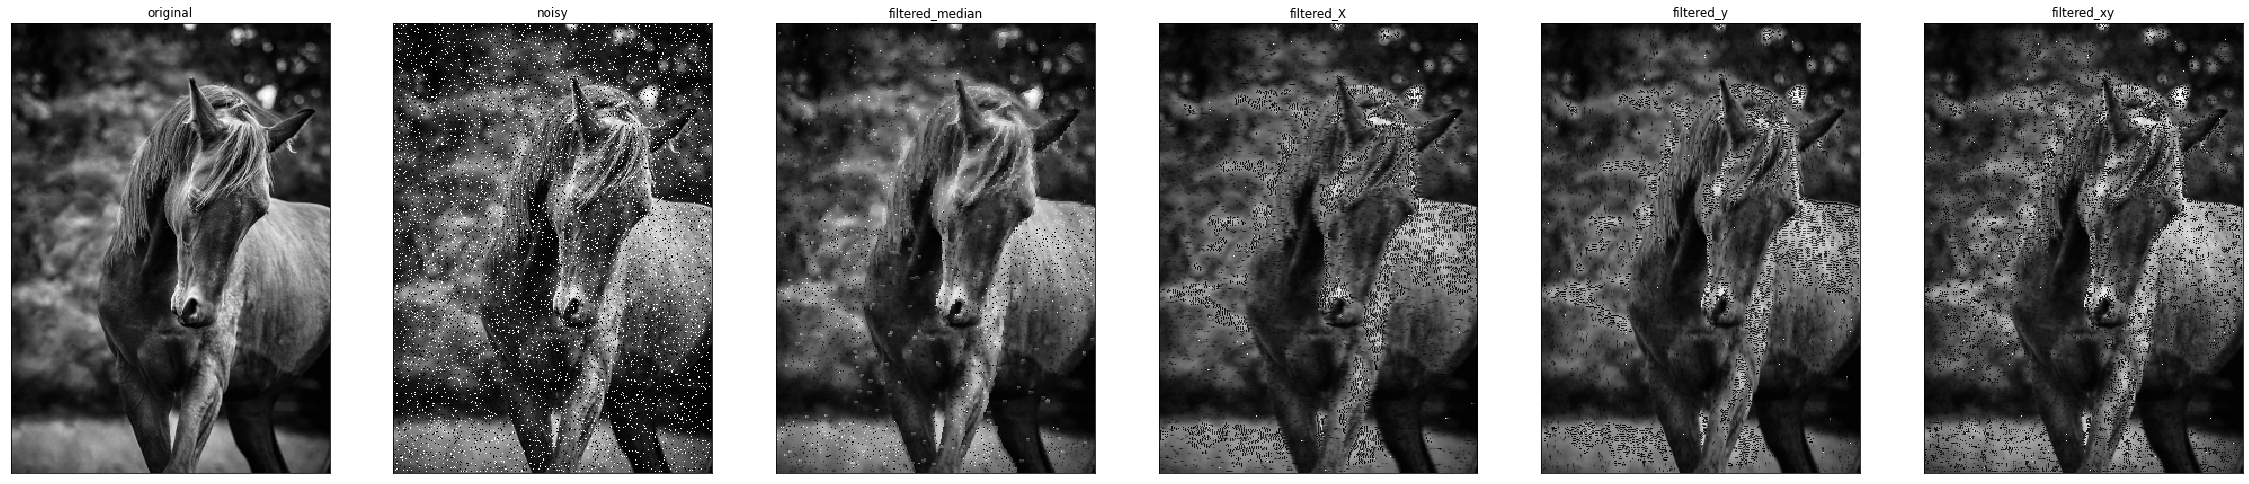

In [217]:
def denoise_median(gradient, der):
  gradient = sig.convolve2d(noisy_img_debug, der, mode='same')
  # Extract all the pixel locations where a noise is suspected to be according the 
  # defined thresholds above.
  salt_noise_rows, salt_noise_cols = np.where(gradient > threshold_max)
  salt_noise_locations = np.array(list(zip(salt_noise_rows, salt_noise_cols)))

  pepper_noise_rows, pepper_noise_cols = np.where(gradient < threshold_min)
  pepper_noise_locations = np.array(list(zip(pepper_noise_rows, pepper_noise_cols)))

  # For each location found above, find the median in a neighbourhood centered
  # at that location
  center_offset = 1 # window is 3x3
  if len(pepper_noise_locations) > 0 and len(salt_noise_locations) > 0:
    noise_locations = np.concatenate(list(zip(pepper_noise_locations, salt_noise_locations)))
  else:
    noise_locations = pepper_noise_locations if len(pepper_noise_locations) > 0 else salte_noise_locations
  for loc in noise_locations:
    x, y = loc[0], loc[1]
    if x - center_offset >= 0 and x + center_offset < rows and y - center_offset >= 0 and y + center_offset  < cols:
      area = noisy_img_debug[x-center_offset:x+center_offset, y-center_offset:y+center_offset]
      noisy_img_debug[x-center_offset:x+center_offset, y-center_offset:y+center_offset] = np.median(area)

rows, cols = G_x.shape[0], G_x.shape[1]
threshold_max = 150
threshold_min = -250

noisy_img_debug = noisy_img.copy()
# smooth image while keeping edges sharp
noisy_img_debug = cv.bilateralFilter(noisy_img_debug,1,50,50) 

denoise_median(G_x, dX)
denoise_median(G_y, dY)

fig = plt.figure(figsize=(40,40))
title = ['original', 'noisy', 'filtered_median', 'filtered_X', 'filtered_y', 'filtered_xy']
for i, img in enumerate([image_gray, noisy_img, dst, filtered_x, filtered_y, filtered_xy]):
  plt.subplot(1,len(title),i+1)
  plt.imshow(img, cmap='gray', interpolation='none')
  plt.title(title[i])
  plt.xticks([])
  plt.yticks([])


The median filter has removed the most noise among the other methods, however it lost a lot of the sharp edges in the original image.

Now will take each 3x3 block in the image and apply the median filter on it (regardless if there is noise in this block or not)

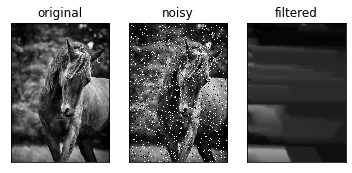

In [218]:
noisy_img_debug = noisy_img.copy()
center_offset = 1 # window is 3x3
for x in range(noisy_img_debug.shape[0]):
  for y in range(noisy_img_debug.shape[1]):
    if x - center_offset >= 0 and x + center_offset < noisy_img_debug.shape[0] and y - center_offset >= 0 and y + center_offset  < noisy_img_debug.shape[1]:
        area = noisy_img_debug[x-center_offset:x+center_offset, y-center_offset:y+center_offset]
        noisy_img_debug[x-center_offset:x+center_offset, y-center_offset:y+center_offset] = np.median(area)


fig = plt.figure()
title = ['original', 'noisy', 'filtered']
for i, img in enumerate([image_gray, noisy_img, noisy_img_debug]):
  plt.subplot(1,len(title),i+1)
  plt.imshow(img, cmap='gray', interpolation='none')
  plt.title(title[i])
  plt.xticks([])
  plt.yticks([])



No more SaP noise, of course. And no more image.

## Using NN/CNN to reduce the noise

## Neural Network model
**NOTE1:** this experiment is failing so far: only good outputs been yield when there is black image with salt noise. My guesses are because the noise are very random (hence could be part of the image) and the model is very structured.
Using a CNN could have given better results.

**NOTE2:** The best thing i'm taking from this is: experimenting with image scrapping from Google, building a dataset and working with PyTorch.

In the following section will build a model based on a dense NN that receives an image with SaP noise and outputs an image without noise.
Since the image could be relatively large (400x800) it's ineffecient to flatten it and pass it as is to the network, therefor the first approach is to segment the image to smaller sizes like 28x28 and then we can feed it to the model.

Using the MNIST digits dataset is not a good idea because all the images there have the same structure - black background with white in the middle of a digit, so the model won't learn much from those images.

Instead, will scrap random images from Google and use those instead.
Since Goolgle gives images of varios sizes, we need to slice those images in order to satisfy the 28x28 size condition (this could also be regarded as image augmenttion).





In [ ]:
import imageNoiseFilter.image_noise as noise

dataset = noise.SaP_dataset().prepare()
train_imgs, train_labels = dataset.get_training_baches(50)

train_imgs.shape, train_labels.shape

preparing the dataset
calculating training batches: tota 12756 batch_size 255


(torch.Size([50, 255, 784]), torch.Size([50, 255, 784]))

In [ ]:
import random
model = nn.Sequential(
    nn.Linear(in_features=784, out_features=1000),
    nn.ReLU(),
    nn.Linear(in_features=1000, out_features=784),
    nn.ReLU(),
)
loss_fn= nn.MSELoss()
optim = torch.optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9)
def train_model(epochs):
  idx = [i for i in range(train_labels.shape[1])]
  for _ in range(epochs):
    random.shuffle(idx)
    for i in idx:
      x,y = train_imgs[0][i],train_labels[0][i]
      predictions = model(x)
      loss = loss_fn(predictions, y)
      optim.zero_grad()
      loss.backward()
      optim.step()

train_model(400)

In [ ]:
def test_model():
  test_imgs, test_labels = dataset.get_test_data()
  print(test_imgs.shape, test_labels.shape)
  right_guesses = 0
  for idx, img in enumerate(test_imgs):
    lbl = test_labels[idx]
    predection = model(img)
    res = (abs(predection - lbl) < 0.01).float().sum().item()
    if res >= 700: # to get the same exact image we need all 784 pixels to match, but here it's checking for at least ~90% accuracy 
      right_guesses += 1
      # i = torch.reshape(predection, (28,28)).detach().numpy()
      # i_o = torch.reshape(img, (28,28)).detach().numpy()
      # fig = plt.figure()
      # fig.set_size_inches(2.5, 1.5)
      # title = ['original', 'predicted']
      # for i, img in enumerate([i_o, i]):
      #   plt.subplot(1,len(title),i+1)
      #   plt.imshow(img, cmap='gray', interpolation='none')
      #   plt.title(title[i])
      #   plt.xticks([])
      #   plt.yticks([])
      

  print('right_guesses', right_guesses, 'accuracy', (right_guesses)/len(test_labels))

test_model()

Seems like the network can only predict right the black images with salt noise.
Also, in the last image, there is some gray at the bottom which got filtered to blaack at the predicted image.

A large aspect of the low accuracy can be attributed to the fact that there is very little data to train the network on (50 batches of 254 images each hence ~10k samples).

One way to solve part of this problem is to use image augmentation techniques:
- rotating the image.
- resizing.
- applying multiple noises to the same image.
- smooth the image before feeding it to the model (for both training and predicting)


In [ ]:
dataset.augment_image_dataset()
train_imgs, train_labels = dataset.get_training_baches(50)
train_model(200)
test_model()
